0. Import the data and declare your package dependencies.

In [12]:
import pandas as pd
from plotnine import *

avocados = pd.read_csv("avocado-updated-2020.csv")

1. Briefly describe the data set. What information does it contain?

The dataset contains information about Hass avocados from the year 2015 to 2020. It includes the city or region, date, average price, avocado size, total volume, and type (organic vs. conventional) for each observation. The avocados are categorized based on their PLU number (product/price lookup) where 4046 refers to small/medium Hass avocados, 4225 refers to large Hass avocados, and 4770 refers to extra large Hass avocados. This dataset allows you to gain more insights into avocado pricing trends, looking at trends across time, across regions, as well as volume and demand trends.

2. Clean the data in any way you see fit.

In [16]:
avocados = avocados.rename(columns = {"4046":"small", "4225": "large", "4770": "xlarge"})

# create dataset with major regions
regions_major = pd.DataFrame({
    "geography" : ["West", "Great Lakes", "Midsouth", "Northeast", 
                "Southeast", "South Central", "West Tex/New Mexico", "Plains", "California", 
                "Northern New England", "New York", "South Carolina"]
})

# create dataset with minor regions 
regions_national = pd.DataFrame({
    "geography" : ["Total U.S."]
})

# cleaned avocados dataset
avocados_clean = avocados.merge(regions_major, on="geography", how="left", indicator=True)
avocados_clean = avocados_clean[avocados_clean['_merge'] == 'left_only'].drop(columns=['_merge'])
avocados_clean = avocados_clean.merge(regions_national, on="geography", how="left", indicator=True)
avocados_clean = avocados_clean[avocados_clean['_merge'] == 'left_only'].drop(columns=['_merge'])


#dataset that includes only major regions
avocados_major = avocados.merge(regions_major, on = ["geography"])



3. Which major geographical region sold the most total organic, small Hass avocados in 2017?

The region that sold the most total organic, small Hass avocados in 2017 was West.

In [18]:
major_reg = avocados_major[(avocados_major["year"] == 2017) & (avocados_major["type"] == "organic")]
major_reg

major_reg.groupby("geography")["small"].sum().idxmax()

'West'

4. Split the date variable into month, day, and year variables. In which month is the highest average volume of avocado sales?

The month with the highest average volume of avocado sales is May.

In [19]:
avocados_clean["date"] = pd.to_datetime(avocados_clean["date"])

#create year column
avocados_clean["year"] = avocados_clean["date"].dt.year

#create month column
avocados_clean["month"] = avocados_clean["date"].dt.month

#create day column
avocados_clean["day"] = avocados_clean["date"].dt.day

#find the month with highest avg volume of avocado sales
avocados_clean.groupby("month")["total_volume"].mean().idxmax()

np.int32(5)

5. Which metro area geographical regions sold the most total avocados? Plot side-by-side box-plots of the total volume for only the five metro geographical regions with the highest averages for the total_volume variable.

The regions that sold the most avocados on average were Los Angeles, Denver, Dallas-Fortworth, Houston, and Phoenix/Tucson. The top metro region that sold the most avocados on average was Los Angeles.

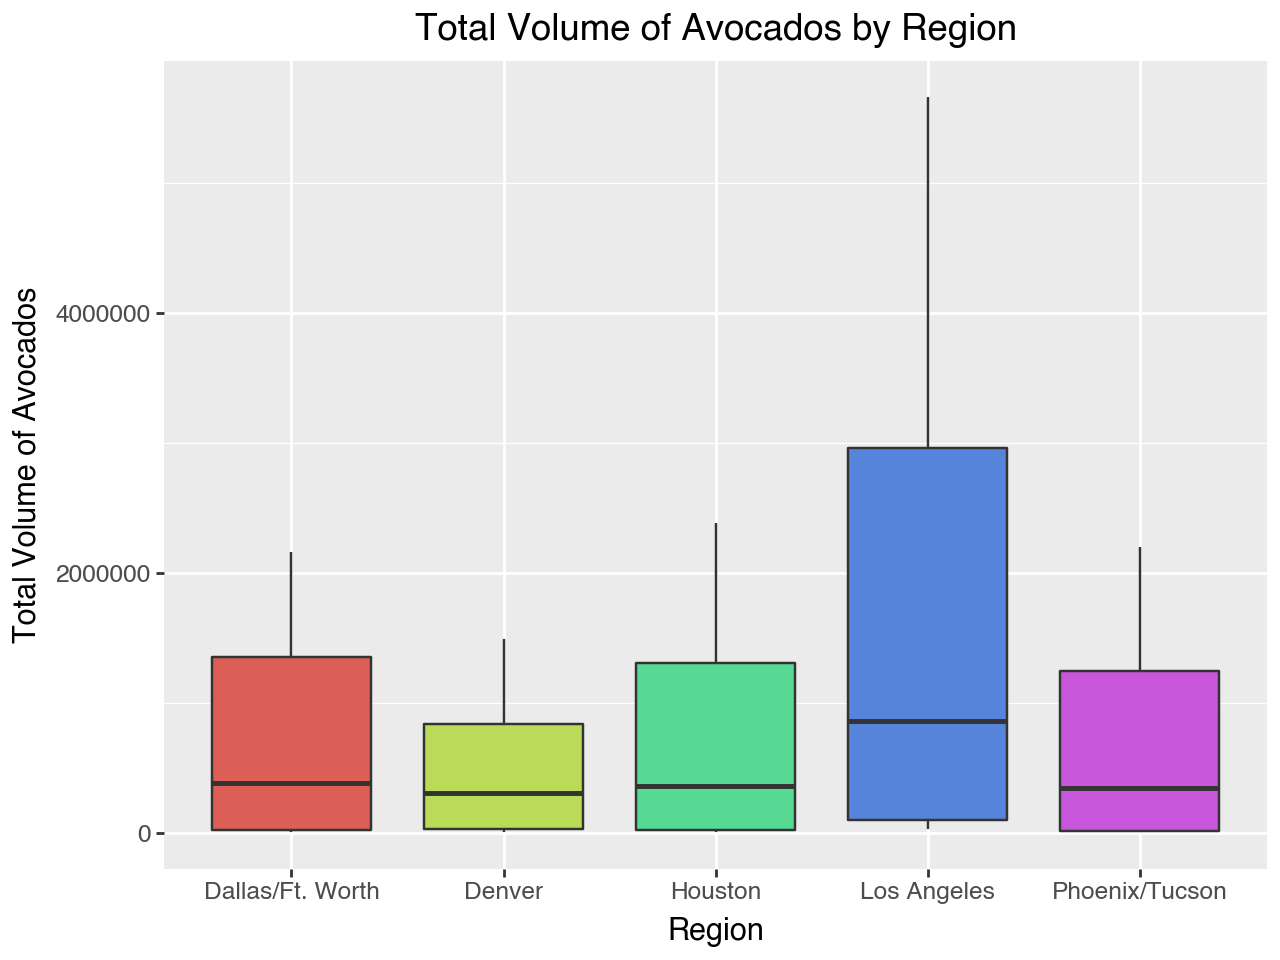

In [34]:
# find the top 5 regions
metro =(avocados_clean.groupby("geography")["total_volume"].mean().nlargest(5).reset_index())

# merge new dataset with cleaned dataset
avocados_metro = avocados_clean.merge(metro, on = "geography")
avocados_metro = avocados_metro[["geography", "total_volume_x"]]

# creat boxplots
(ggplot(avocados_metro, aes(x = "geography", y = "total_volume_x", fill = "geography"))
        + geom_boxplot()
        + labs(y = "Total Volume of Avocados", x = "Region", 
                title = "Total Volume of Avocados by Region")
        + theme(legend_position="none")
)



6. From your cleaned data set, create a data set with only these California regions and answer the following questions about these California regions only.

In [35]:
ca_cities = pd.DataFrame({
    "geography": ["San Diego", "San Francisco", "Los Angeles", "Sacramento"]
})

ca_avocados = avocados_clean.merge(ca_cities, on = "geography")

7. In which California regions is the price of organic versus conventional avocados most different? Support your answer with a few summary statistics AND a visualization.

The California region with the most differnt price of organic versus conventional avocados was San Franciso. San Francisco had the highest average and median difference as well as the highest maximum difference.

       geography      mean  median   min   max       std
0    Los Angeles  0.527778    0.53  0.07  1.21  0.188143
1     Sacramento  0.578497    0.54 -0.09  1.43  0.270029
2      San Diego  0.684510    0.67  0.20  1.41  0.211286
3  San Francisco  0.718954    0.71  0.02  1.59  0.333801
       geography      mean  median   min   max       std
0    Los Angeles  0.527778    0.53  0.07  1.21  0.188143
1     Sacramento  0.578497    0.54 -0.09  1.43  0.270029
2      San Diego  0.684510    0.67  0.20  1.41  0.211286
3  San Francisco  0.718954    0.71  0.02  1.59  0.333801


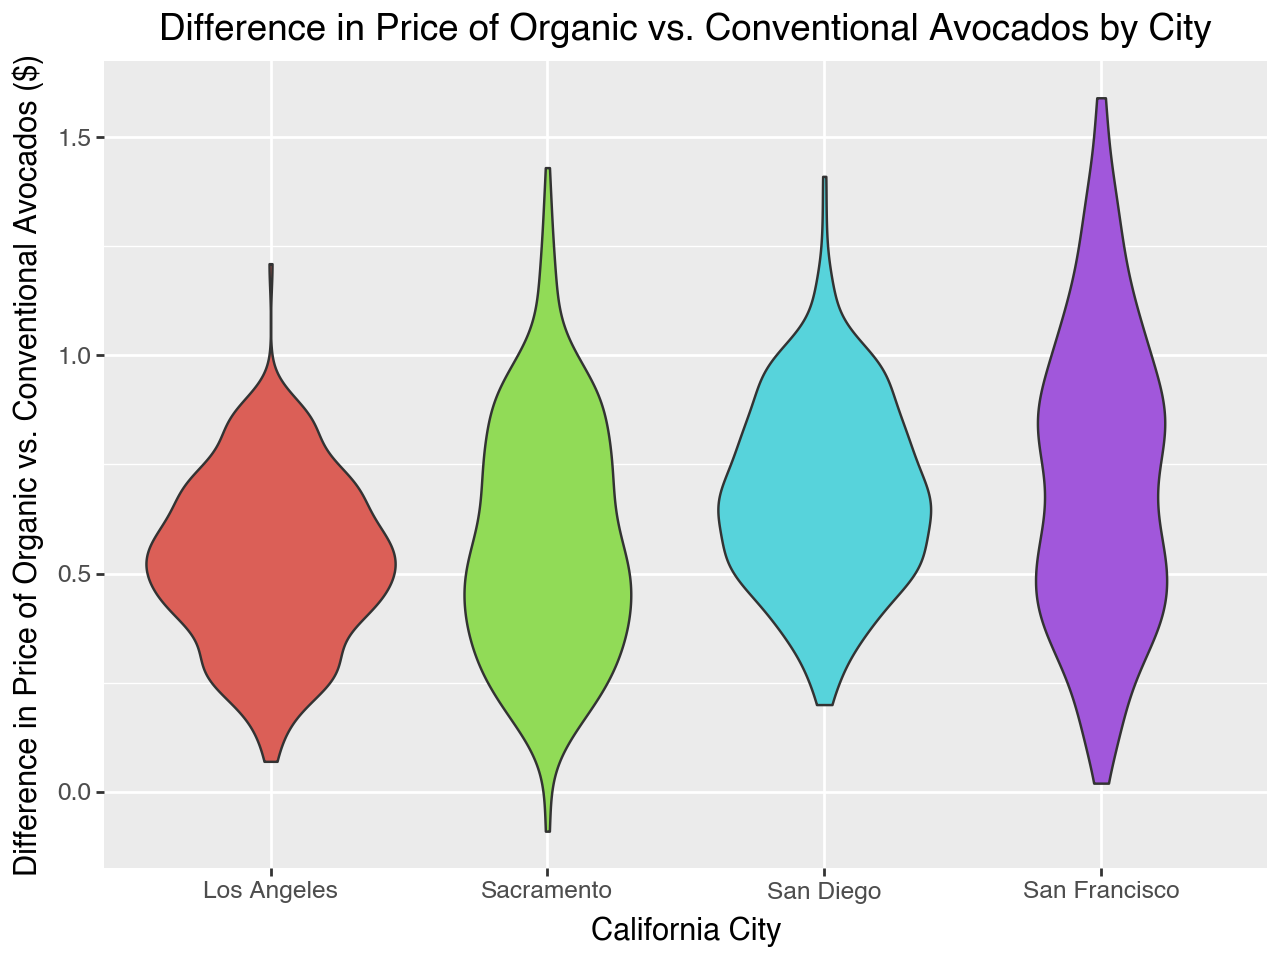

In [39]:
ca_avo_prices = ca_avocados.groupby(["geography", "type", "date"])["average_price"].mean().reset_index()
ca_prices_long = ca_avo_prices.pivot(index = ["geography", "date"], columns = "type", values = "average_price")
ca_prices_long["diff"] = ca_prices_long["organic"] - ca_prices_long["conventional"]
ca_prices_long = ca_prices_long.reset_index()

#summary statistics
summary_stats = ca_prices_long.groupby('geography')['diff'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
print(summary_stats)

(ggplot(ca_prices_long, aes(x = "geography", y = "diff", fill = "geography"))
+ geom_violin()
+ labs(x = "California City", y = "Difference in Price of Organic vs. Conventional Avocados ($)",
       title = "Difference in Price of Organic vs. Conventional Avocados by City")
+ theme(legend_position="none")
)

8. The following plot shows, for all four California regions, the proportion of the average Hass avocado sales that are small, large, or extra large; conventional vs. organic. Recreate the plot; you do not have to replicate the exact finishing touches - e.g., color, theme - but your plot should resemble the content of this plot.

In [40]:
ca_plot = ca_avocados.melt(id_vars = ["geography", "type"], 
                            value_vars=["small", "large", "xlarge"], 
                            var_name= "avo_size", 
                            value_name="volume")
avg_size = ca_plot.groupby(["avo_size", "type", "geography"])["volume"].mean().reset_index()
avg_size
total = avg_size.groupby(["type", "geography"])["volume"].sum().reset_index()
total
ca_prop = avg_size.merge(total, on = ["type", "geography"])
ca_prop["prop"] = ca_prop["volume_x"]/ca_prop["volume_y"]


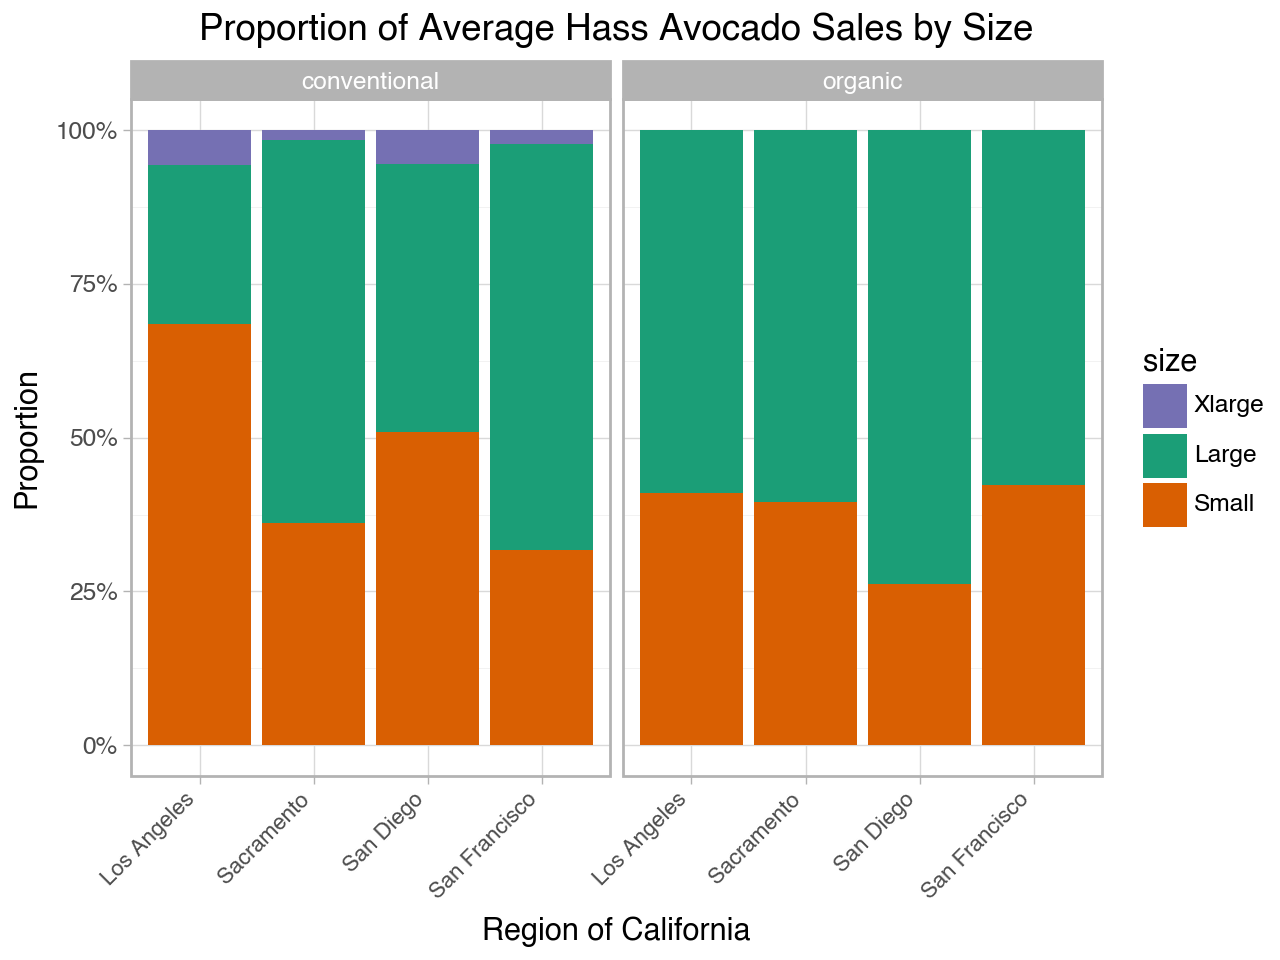

In [45]:
# import percent_format function
from mizani.formatters import percent_format

#reorder avo_size attribute

ca_prop["avo_size"] = pd.Categorical(ca_prop['avo_size'], 
                                     categories=['xlarge', 'large', 'small'],
                                     ordered=True)

#create plot
(ggplot(ca_prop, aes(x = "geography", y = "prop", fill = "avo_size"))
        + geom_bar(stat="identity", position="stack")
        + facet_wrap("~type")
        + labs(x = "Region of California", y = "Proportion", 
               title = "Proportion of Average Hass Avocado Sales by Size",
               fill = "size")
        + scale_fill_manual(values = ["#7570b3", "#1b9e77", "#d95f02"], breaks = ["xlarge", "large", "small"],
                            labels = ["Xlarge", "Large", "Small"])
        + scale_y_continuous(labels=percent_format())
        + theme_light()
        + theme(axis_text_x = element_text(size = 8, angle=45, hjust=1))
               )



# Using Outside Data

A joke in the media is that Millennials can’t afford houses, because they spend all their money buying avocado toast. Let’s use this data set to address that claim.

Find or make a data set with house prices for these four California regions. Join this data set with your California avocado data set.

Use your new joined data set to make an argument about the relationship between house prices and avocado prices/sales.

Support your argument with a plot.

Looking at the plot below, there doesn't appear to be a strict relationship between housing prices and total volume of avocados. However, individuals in Los Angeles purchase a significantly more amount of avocados than other areas. San Francisco also purchases 

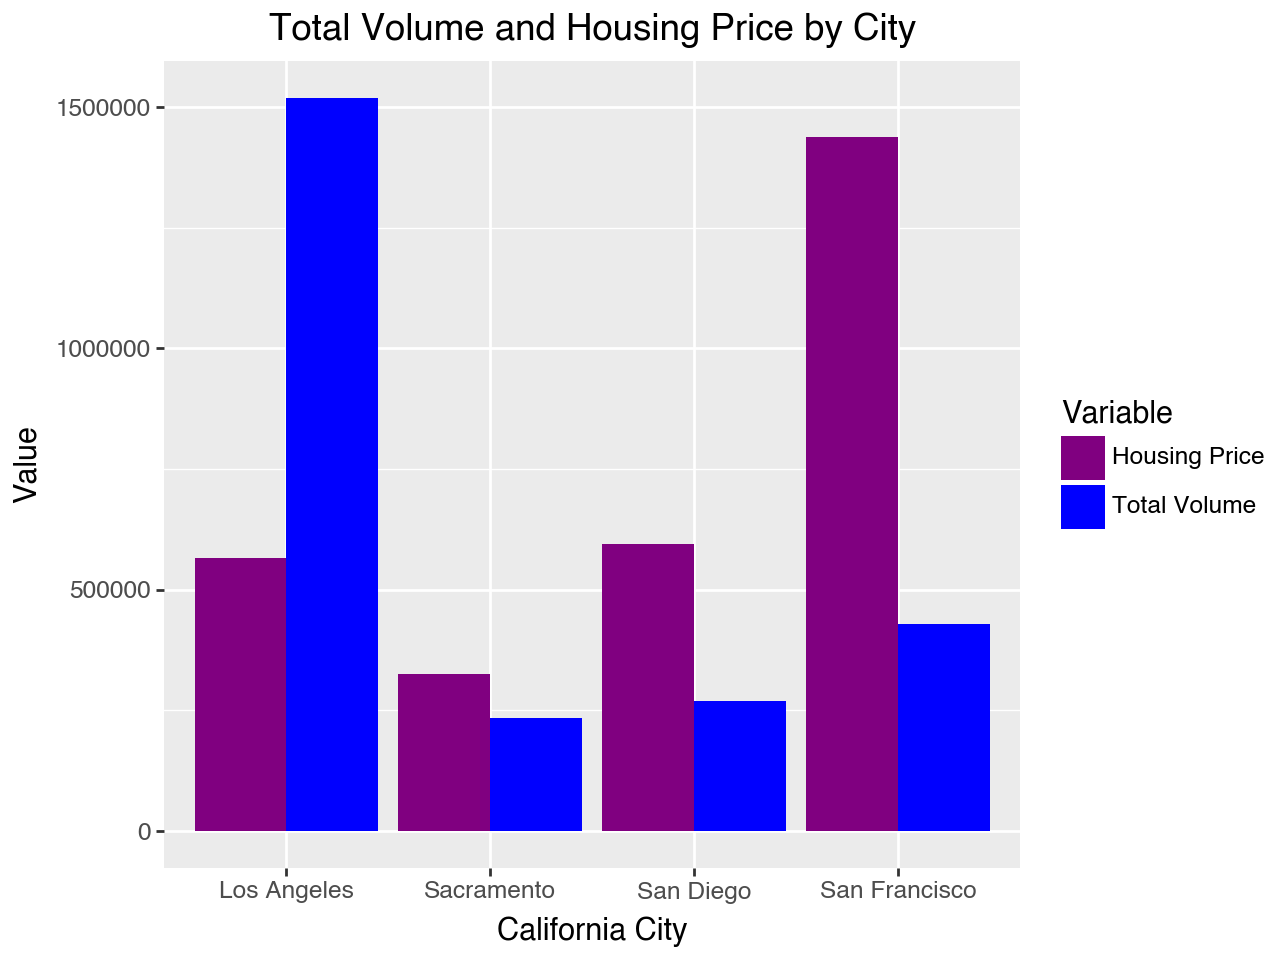

In [44]:
housing = pd.read_csv("housing.csv")

avo_housing = ca_avocados.merge(housing, on = ["geography", "year"]).reset_index()
avo_housing = avo_housing.groupby(["geography"])[["total_volume", "housing_price"]].mean().reset_index()

avo_long = pd.melt(avo_housing, id_vars='geography', value_vars=['total_volume', 'housing_price'], 
                  var_name='Variable', value_name='Value')

(ggplot(avo_long, aes(x='geography', y='Value', fill='Variable'))
        + geom_bar(stat='identity', position=position_dodge())
        + labs(x='California City', y='Value', title='Total Volume and Housing Price by City')
        + scale_fill_manual(labels=["Housing Price", "Total Volume"], values=["purple", "blue"])
       )

# Appendix

Question 3: the .idxmax() function was used to find the region with the highest small avocados.
.idxmax() function: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html 

Question 8: percent format
https://stackoverflow.com/questions/52625307/how-to-change-the-y-axis-to-display-percent-in-python-plotnine-barplot 

Question 8: rotating labels
https://stackoverflow.com/questions/47714540/plotnine-rotating-labels 

Sources for housing data
https://www.laalmanac.com/economy/ec37.php#google_vignette
https://www.rereport.com/sf/index_a.html
https://media.sdar.com/media/December2015HousingStats.pdf#:~:text=(The%20median%20price%20increase%20for%20the%20year,for%20condominiums%20and%20townhomes%20was%20nearly%20$360%2C000.

Generative AI Statement: 
Generative AI was used in this lab to assist in cleaning the data, specifically with dropping the columns with _merge. In addition, it was used in created the summary statistics using the agg function as well as reordering the legend label in the bar plot.